# Cleaning: BJH016


This script cleans the data both by abnormal trials and by noisy channels and epileptic activity.



### Prep

In [1]:
import matplotlib
# matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
from BCI2kReader import BCI2kReader as b2k
import os
import mne
from tabulate import tabulate
import IPython
import seaborn as sns

In [2]:
# %matplotlib qt5

In [3]:
# helper functions#

def rle(inarray):
        """ run length encoding. Partial credit to R rle function. 
            Multi datatype arrays catered for including non Numpy
            returns: tuple (runlengths, startpositions, values) """
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]               # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)   # must include last element posi
            z = np.diff(np.append(-1, i))       # run lengths
            p = np.cumsum(np.append(0, z))[:-1] # positions
            return(z, p, ia[i])
        
def find_bad_trial_times(idx, srate, trial_begins, trial_lengths):
    ''' takes and index of trial lengths, beginnings and the sampling rate and returns the the start time and and
    duration of the times to annotae as BAD '''
    start_time = trial_begins[0][idx]/srate
    duration = trial_lengths[0][idx]/srate
    
    return start_time, duration        

In [4]:
## Prep paths ##

subject = 'BJH016'
orig_data_fi = '/home/brooke/knight_server/remot"e/WashU/data/PacmanTask/BJH016/PacmanTask/ECOGS001R01.dat'
raw_data_dir = f"/home/brooke/pacman/raw_data/{subject}"
preproc_data_dir = f"/home/brooke/pacman/preprocessing/{subject}/ieeg"

In [5]:
## Load Data ##

raw_fif = mne.io.Raw(f"{raw_data_dir}/ieeg/{subject}_raw_ieeg.fif")

Opening raw data file /home/brooke/pacman/raw_data/BJH016/ieeg/BJH016_raw_ieeg.fif...
    Range : 0 ... 1963999 =      0.000 ...   982.000 secs
Ready.
Opening raw data file /home/brooke/pacman/raw_data/BJH016/ieeg/BJH016_raw_ieeg-1.fif...
    Range : 1964000 ... 3927999 =    982.000 ...  1963.999 secs
Ready.
Opening raw data file /home/brooke/pacman/raw_data/BJH016/ieeg/BJH016_raw_ieeg-2.fif...
    Range : 3928000 ... 5891999 =   1964.000 ...  2945.999 secs
Ready.
Opening raw data file /home/brooke/pacman/raw_data/BJH016/ieeg/BJH016_raw_ieeg-3.fif...
    Range : 5892000 ... 5901899 =   2946.000 ...  2950.950 secs
Ready.


In [6]:
raw_fif.info

<Info | 10 non-empty values
 bads: []
 ch_names: EMPTY, EMPTY_2, EMPTY_3, EMPTY_4, REF1, REF2, AL1, AL2, AL3, ...
 chs: 272 sEEG, 1 Stimulus
 custom_ref_applied: False
 dig: 0 items
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 273
 projs: []
 sfreq: 2000.0 Hz
>

In [7]:
## Filtering ##

# load data #
raw_fif.load_data()

# highpass filter @ 1 and lowpass @ 200 #
filtered_data = raw_fif.copy().filter(l_freq=1, h_freq=150) # skip this step for TF analysis, always do this on the least processed data, or do .1 to 250

# remove 60hz line noise #
freqs = (60, 120, 180, 240)
filtered_notch_data = filtered_data.notch_filter(freqs=freqs) 


Reading 0 ... 5901899  =      0.000 ...  2950.950 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 150.00 Hz
- Upper transition bandwidth: 37.50 Hz (-6 dB cutoff frequency: 168.75 Hz)
- Filter length: 6601 samples (3.300 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13201 samples (6.601 

In [15]:
raw_fif.info

<Info | 10 non-empty values
 bads: []
 ch_names: EMPTY, EMPTY_2, EMPTY_3, EMPTY_4, REF1, REF2, AL1, AL2, AL3, ...
 chs: 272 sEEG, 1 Stimulus
 custom_ref_applied: False
 dig: 0 items
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 273
 projs: []
 sfreq: 2000.0 Hz
>

In [8]:
## Load/Save Filtered Data ##

# save #
# filtered_notch_data.save(f"{raw_data_dir}/ieeg/{subject}_notched_filtered_ieeg.fif", overwrite = True)

# load #
filtered_notch_data = mne.io.Raw(f"{raw_data_dir}/ieeg/{subject}_notched_filtered_ieeg.fif")
events = mne.find_events(filtered_notch_data, output='step', consecutive = False, stim_channel='STI')

Opening raw data file /home/brooke/pacman/raw_data/BJH016/ieeg/BJH016_notched_filtered_ieeg.fif...
    Range : 0 ... 1963999 =      0.000 ...   982.000 secs
Ready.
Opening raw data file /home/brooke/pacman/raw_data/BJH016/ieeg/BJH016_notched_filtered_ieeg-1.fif...
    Range : 1964000 ... 3927999 =    982.000 ...  1963.999 secs
Ready.
Opening raw data file /home/brooke/pacman/raw_data/BJH016/ieeg/BJH016_notched_filtered_ieeg-2.fif...
    Range : 3928000 ... 5891999 =   1964.000 ...  2945.999 secs
Ready.
Opening raw data file /home/brooke/pacman/raw_data/BJH016/ieeg/BJH016_notched_filtered_ieeg-3.fif...
    Range : 5892000 ... 5901899 =   2946.000 ...  2950.950 secs
Ready.
904 events found
Event IDs: [0 1]


## Cleaning Neural Data

#### Bad Channels

Epileptic channels from my cleaning: Gl1, GL2, GL3, HL1, HL2

Epileptic channels from cleaning w/ Rebecca: HL1, HL2, HL3; IL1, IL2, IL3

Noisy channels: BL1, F8, EL1, EL2 , HL14, HL15, HL16

In [9]:
# Remove Channels from filtered data

# remove non seeg electrodes electrodes #
string_lst = ['EMPTY', 'REF', 'ekg']

bad_channels_reg = [re.findall(r"(?=("+'|'.join(string_lst)+r"))", name, re.IGNORECASE) for name in filtered_notch_data.info['ch_names']]
bad_channels_index = [i for i,x in enumerate(bad_channels_reg) if  x]
bad_channels = [filtered_notch_data.info['ch_names'][i] for i in bad_channels_index]

filtered_notch_data.info['bads'].extend(bad_channels)  

# remove epileptic electrodes
filtered_notch_data.info['bads'].append('GL1')  
filtered_notch_data.info['bads'].append('GL2')  
filtered_notch_data.info['bads'].append('GL3')  
filtered_notch_data.info['bads'].append('HL1')  
filtered_notch_data.info['bads'].append('HL2')  
filtered_notch_data.info['bads'].append('HL3')
filtered_notch_data.info['bads'].append('HL4') ## added myself looking at signal quality w/ Anais
filtered_notch_data.info['bads'].append('IL1')  
filtered_notch_data.info['bads'].append('IL2')  
filtered_notch_data.info['bads'].append('IL3')


# remove noisy electrodes
filtered_notch_data.info['bads'].append('BL1')  
filtered_notch_data.info['bads'].append('F8')  
filtered_notch_data.info['bads'].append('EL1')  
filtered_notch_data.info['bads'].append('EL2')  
filtered_notch_data.info['bads'].append('HL14')  
filtered_notch_data.info['bads'].append('HL15')  
filtered_notch_data.info['bads'].append('HL16')  

# remove out of brain electrodes
filtered_notch_data.info['bads'].append('BL16') 
filtered_notch_data.info['bads'].append('DL14')
filtered_notch_data.info['bads'].append('EL12')
filtered_notch_data.info['bads'].append('FL12')
filtered_notch_data.info['bads'].append('GL16')
filtered_notch_data.info['bads'].append('GL15')
filtered_notch_data.info['bads'].append('HL16')
filtered_notch_data.info['bads'].append('IL16')
filtered_notch_data.info['bads'].append('JL14')
filtered_notch_data.info['bads'].append('KL16')
filtered_notch_data.info['bads'].append('NR12')
filtered_notch_data.info['bads'].append('OR16')


# remove scalp and dc channels
scalp_dc_channels = ['FP1',
 'F3',
 'C3',
 'P3',
 'O1',
 'FP2',
 'F4',
 'C4',
 'P4',
 'O2',
 'F7',
 'T7',
 'P7',
 'F8',
 'T8',
 'P8',
 'F9',
 'F10',
 'FPZ',
 'FZ',
 'CZ',
 'PZ',
 'OZ',
 'DC01',
 'DC02',
 'DC03',
 'DC04',
 'DC05',
 'DC06',
 'DC07',
 'DC08',
 'DC09',
 'DC10',
 'DC11',
 'DC12',
 'DC13',
 'DC14',
 'DC15',
 'DC16']

filtered_notch_data.info['bads'].extend(scalp_dc_channels)
filtered_notch_data

<Raw | BJH016_notched_filtered_ieeg.fif, 273 x 5901900 (2950.9 s), ~276 kB, data not loaded>

In [10]:
# Remove Channels from raw data

# remove non seeg electrodes electrodes #
string_lst = ['EMPTY', 'REF', 'ekg']

bad_channels_reg = [re.findall(r"(?=("+'|'.join(string_lst)+r"))", name, re.IGNORECASE) for name in raw_fif.info['ch_names']]
bad_channels_index = [i for i,x in enumerate(bad_channels_reg) if  x]
bad_channels = [raw_fif.info['ch_names'][i] for i in bad_channels_index]

raw_fif.info['bads'].extend(bad_channels)  

# remove epileptic electrodes
raw_fif.info['bads'].append('GL1')  
raw_fif.info['bads'].append('GL2')  
raw_fif.info['bads'].append('GL3')  
raw_fif.info['bads'].append('HL1')  
raw_fif.info['bads'].append('HL2')  
raw_fif.info['bads'].append('HL3')
raw_fif.info['bads'].append('HL4') ## added myself looking at signal quality w/ Anais
raw_fif.info['bads'].append('IL1')  
raw_fif.info['bads'].append('IL2')  
raw_fif.info['bads'].append('IL3')


# remove noisy electrodes
raw_fif.info['bads'].append('BL1')  
raw_fif.info['bads'].append('F8')  
raw_fif.info['bads'].append('EL1')  
raw_fif.info['bads'].append('EL2')  
raw_fif.info['bads'].append('HL14')  
raw_fif.info['bads'].append('HL15')  
raw_fif.info['bads'].append('HL16')  

# remove out of brain electrodes
raw_fif.info['bads'].append('BL16') 
raw_fif.info['bads'].append('DL14')
raw_fif.info['bads'].append('EL12')
raw_fif.info['bads'].append('FL12')
raw_fif.info['bads'].append('GL16')
raw_fif.info['bads'].append('GL15')
raw_fif.info['bads'].append('HL16')
raw_fif.info['bads'].append('IL16')
raw_fif.info['bads'].append('JL14')
raw_fif.info['bads'].append('KL16')
raw_fif.info['bads'].append('NR12')
raw_fif.info['bads'].append('OR16')


# remove scalp and dc channels
scalp_dc_channels = ['FP1',
 'F3',
 'C3',
 'P3',
 'O1',
 'FP2',
 'F4',
 'C4',
 'P4',
 'O2',
 'F7',
 'T7',
 'P7',
 'F8',
 'T8',
 'P8',
 'F9',
 'F10',
 'FPZ',
 'FZ',
 'CZ',
 'PZ',
 'OZ',
 'DC01',
 'DC02',
 'DC03',
 'DC04',
 'DC05',
 'DC06',
 'DC07',
 'DC08',
 'DC09',
 'DC10',
 'DC11',
 'DC12',
 'DC13',
 'DC14',
 'DC15',
 'DC16']

raw_fif.info['bads'].extend(scalp_dc_channels)
raw_fif

<Raw | BJH016_raw_ieeg.fif, 273 x 5901900 (2950.9 s), ~12.00 GB, data loaded>

#### Bad Epochs

`116-117, 127.5:129, 160-161.5, 343-345, 540-541, 6216-623, 681-683`

In [11]:
# Annotate Noisy Epochs from Bob's cleaning

### Filtered

onsets = [
    filtered_notch_data.first_time + 160, #2
    filtered_notch_data.first_time + 343, #2
    filtered_notch_data.first_time + 520, #1
    filtered_notch_data.first_time + 540.3, #1
    filtered_notch_data.first_time + 561, #1
    filtered_notch_data.first_time + 622, #1
    filtered_notch_data.first_time + 681, #2
    filtered_notch_data.first_time + 1224, #2
    filtered_notch_data.first_time + 1268, #2
    filtered_notch_data.first_time + 1443.5, #1
    filtered_notch_data.first_time + 1507, #1
    filtered_notch_data.first_time + 1555.5, #2
    filtered_notch_data.first_time + 1697, #1
    filtered_notch_data.first_time + 1786, #1
    filtered_notch_data.first_time + 1903, #1.5
    filtered_notch_data.first_time + 1983.5, #1.5
    filtered_notch_data.first_time + 2216.5, #1
    filtered_notch_data.first_time + 2423.5, #2
    filtered_notch_data.first_time + 2515, #1
    filtered_notch_data.first_time + 2526.7, #2.6
    filtered_notch_data.first_time + 2557, #2
    filtered_notch_data.first_time + 2588, #1
    filtered_notch_data.first_time + 2762 #2
    
]

### Raw

onsets = [
    raw_fif.first_time + 160, #2
    raw_fif.first_time + 343, #2
    raw_fif.first_time + 520, #1
    raw_fif.first_time + 540.3, #1
    raw_fif.first_time + 561, #1
    raw_fif.first_time + 622, #1
    raw_fif.first_time + 681, #2
    raw_fif.first_time + 1224, #2
    raw_fif.first_time + 1268, #2
    raw_fif.first_time + 1443.5, #1
    raw_fif.first_time + 1507, #1
    raw_fif.first_time + 1555.5, #2
    raw_fif.first_time + 1697, #1
    raw_fif.first_time + 1786, #1
    raw_fif.first_time + 1903, #1.5
    raw_fif.first_time + 1983.5, #1.5
    raw_fif.first_time + 2216.5, #1
    raw_fif.first_time + 2423.5, #2
    raw_fif.first_time + 2515, #1
    raw_fif.first_time + 2526.7, #2.6
    raw_fif.first_time + 2557, #2
    raw_fif.first_time + 2588, #1
    raw_fif.first_time + 2762 #2
    
]


durations = [2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1.5, 1.5, 1, 2, 1, 2.6, 2, 1, 2]
descriptions = ['bad'] * len(durations)


## Cleaning Bad Trials

In [12]:
## quality check trials ##

# calculate trial onsets and offsets
sti_raw = filtered_notch_data.get_data(picks = ['STI'])
lengths, positionsm, val  = rle(sti_raw[0])

# lengths, beginnings, endings, for trials
trial_lengths = [lengths[x] for x in np.where(val == 1)]
trial_begins = [positionsm[x] for x in np.where(val == 1)]
trial_ends = trial_lengths[0] + trial_begins[0]
trial_baseline = trial_begins[0] - 1000

# lengths, beginnings, endings, for itis
iti_lengths = [lengths[x] for x in np.where(val == 0)]
iti_begins = [positionsm[x] for x in np.where(val == 0)]
iti_ends = iti_begins[0] + iti_lengths[0]

# save trial lengths for later
np.save(f"{preproc_data_dir}/{subject}_trial_lengths.npy", trial_lengths)

In [13]:
# exclude bad trials/apochs via nnotations

# exclude long 30s trial
bad_trial_idx = np.where(trial_lengths[0]/2000 > 30)[0]
start, dur = find_bad_trial_times(bad_trial_idx[0], 2000, trial_begins, trial_lengths)

onsets.append(start)
durations.append(dur)


# update descriptions
descriptions = ['bad'] * len(durations)


In [14]:
# exclude bad trials/apochs from r behavioral analysis (paused trials and no biscuits)

# load bad trial data
bad_trials = np.genfromtxt(f"{raw_data_dir}/behave/{subject}_bad_trials.csv", delimiter = ',', skip_header = 1)

for bad in bad_trials:
    start, dur = find_bad_trial_times(int(bad), 2000, trial_begins, trial_lengths)
    onsets.append(start)
    durations.append(dur)

# update descriptions
descriptions = ['bad'] * len(durations)


## Visualizing Neural Data

In [23]:
## exclude all bad epochs from both bad trials and investigating neural data ##

# create annotations structure #
bad_annots = mne.Annotations(onset=onsets,
                               duration=durations,
                               description=descriptions,
                               orig_time=filtered_notch_data.info['meas_date'])

# apply to filtered data #
filtered_notch_data.set_annotations(bad_annots)


# apply to not filtered data #
raw_fif.set_annotations(bad_annots)

<Raw | BJH016_raw_ieeg.fif, 273 x 5901900 (2950.9 s), ~12.00 GB, data loaded>

In [24]:
raw_fif.info

<Info | 11 non-empty values
 bads: 81 items (EMPTY, EMPTY_2, EMPTY_3, EMPTY_4, REF1, REF2, ...)
 ch_names: EMPTY, EMPTY_2, EMPTY_3, EMPTY_4, REF1, REF2, AL1, AL2, AL3, ...
 chs: 272 sEEG, 1 Stimulus
 custom_ref_applied: False
 dig: 0 items
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 273
 projs: []
 sfreq: 2000.0 Hz
>

next step, working on filtering out the high frequency noise

then look at Marks script to come up with some plot of every trial, sort longest to shortest, with theta power as the color tiome as x, trial on y

Opening raw-browser...


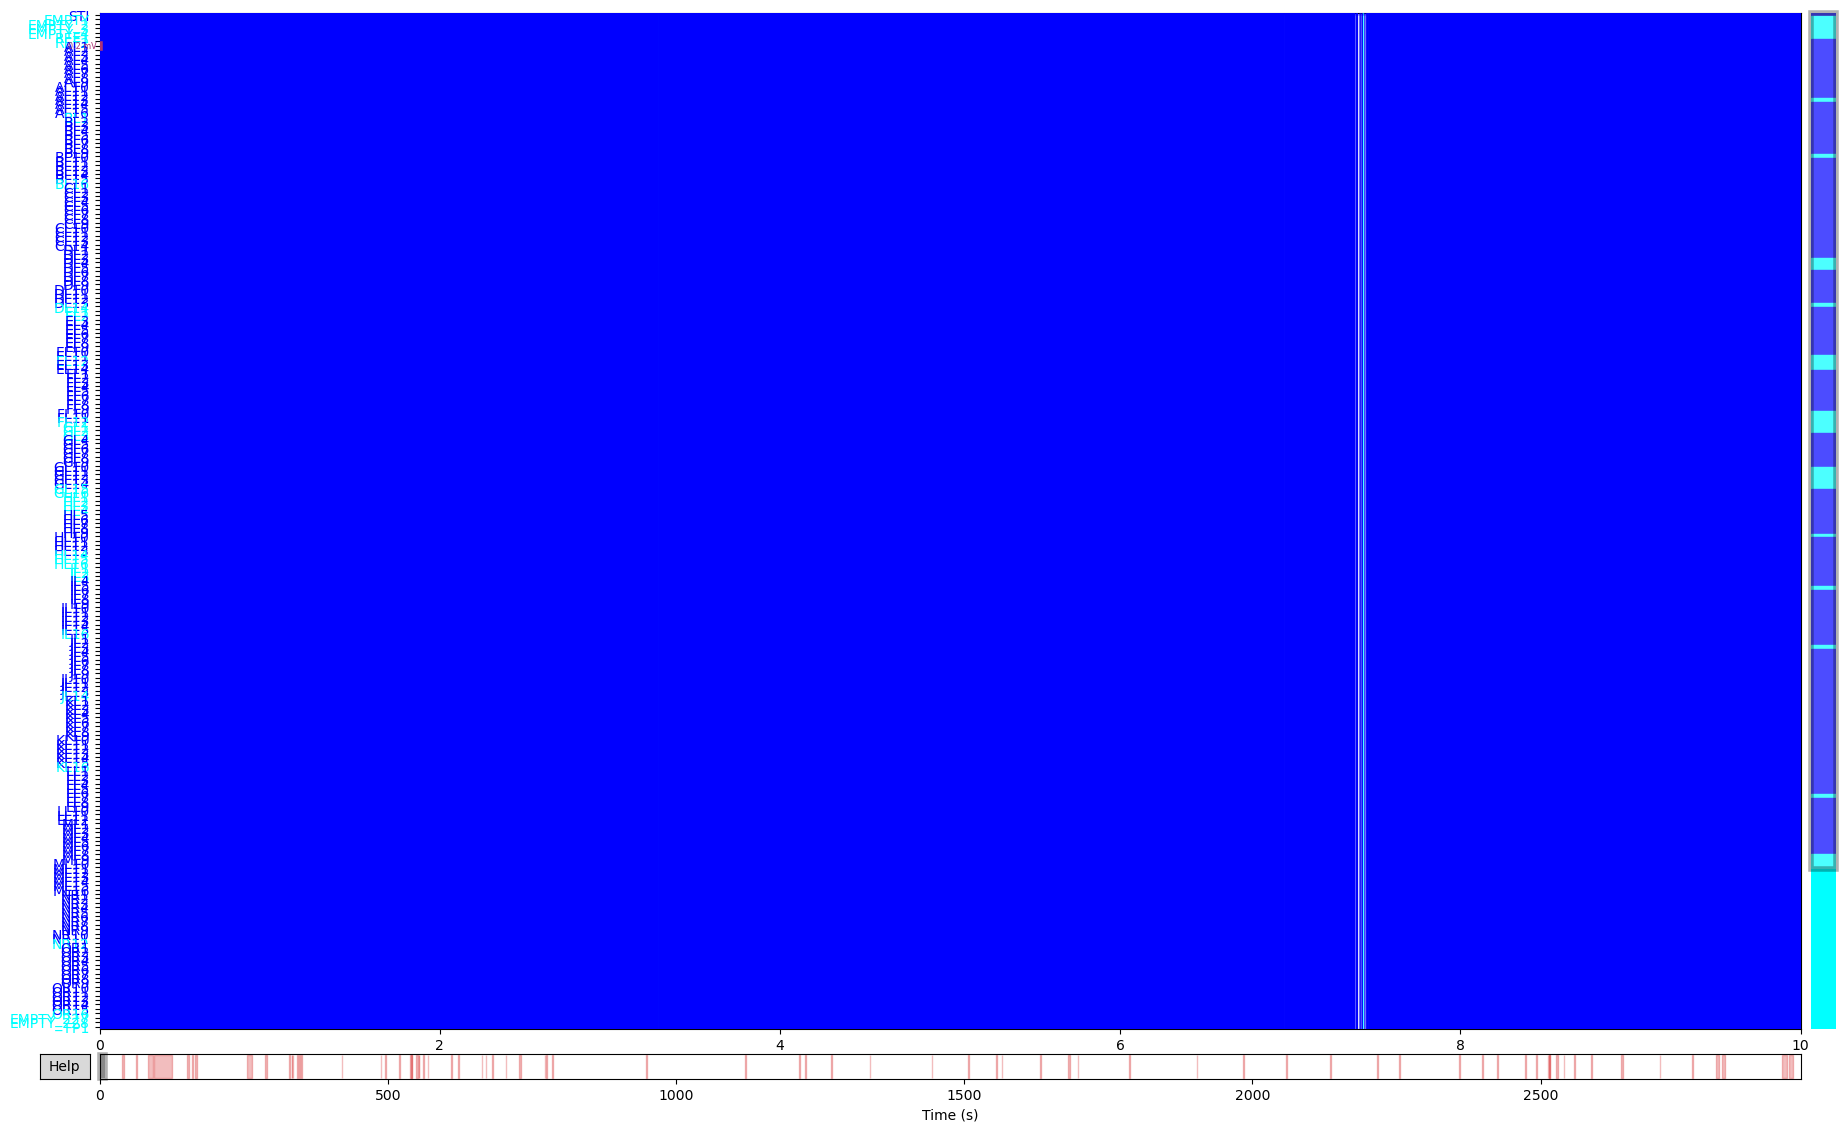

Closing raw-browser...
Channels marked as bad:
['EMPTY', 'EMPTY_2', 'EMPTY_3', 'EMPTY_4', 'REF1', 'REF2', 'EMPTY_228', 'Ekg1', 'ekg2', 'EMPTY_254', 'EMPTY_255', 'EMPTY_256', 'GL1', 'GL2', 'GL3', 'HL1', 'HL2', 'BL1', 'F8', 'EL1', 'EL2', 'HL14', 'HL15', 'HL16', 'EMPTY', 'EMPTY_2', 'EMPTY_3', 'EMPTY_4', 'REF1', 'REF2', 'EMPTY_228', 'Ekg1', 'ekg2', 'EMPTY_254', 'EMPTY_255', 'EMPTY_256', 'GL1', 'GL2', 'GL3', 'HL1', 'HL2', 'HL3', 'HL4', 'IL1', 'IL2', 'IL3', 'BL1', 'F8', 'EL1', 'EL2', 'HL14', 'HL15', 'HL16', 'BL16', 'DL14', 'EL12', 'FL12', 'GL16', 'GL15', 'HL16', 'IL16', 'JL14', 'KL16', 'NR12', 'FP1', 'F3', 'C3', 'P3', 'O1', 'FP2', 'F4', 'C4', 'P4', 'O2', 'F7', 'T7', 'P7', 'F8', 'T8', 'P8', 'F9', 'F10', 'FPZ', 'FZ', 'CZ', 'PZ', 'OZ', 'DC01', 'DC02', 'DC03', 'DC04', 'DC05', 'DC06', 'DC07', 'DC08', 'DC09', 'DC10', 'DC11', 'DC12', 'DC13', 'DC14', 'DC15', 'DC16', 'EMPTY_227', 'OR16']


In [48]:
# plot for cleaning #

filtered_notch_data.plot(events=events, color='b', bad_color = 'cyan', n_channels = 230, clipping = None, event_color = 'r')

Effective window size : 1.024 (s)


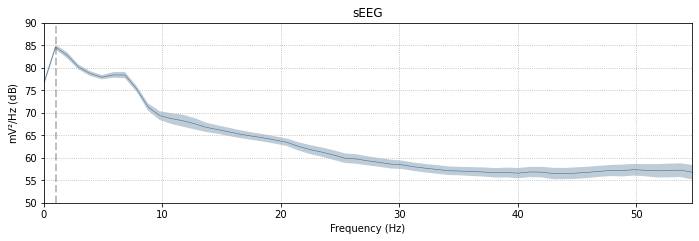

In [29]:
# plot psd of all channels #

# plt.rcParams['figure.figsize'] = [20, 6]


psd_fig = filtered_notch_data.plot_psd(picks = ['OR3', 'OR4', 'OR5', 'OR6'], average = True, fmax = 55, color ='#3A6589', show = False )
ax = plt.gca()
ax.set_ylim([50, 90])
# fig.show()
psd_fig.savefig('/home/brooke/pacman/raw_data/BNP01/BJH016_psd.png', dpi=600)

In [ ]:
# plot psd of bad channels #

filtered_notch_data.plot_psd(picks = filtered_notch_data.info['bads'])

## Save Files

In [25]:
# save filtered data #
filtered_notch_data.save(f"{raw_data_dir}/ieeg/{subject}_notched_filtered_clean_ieeg.fif", overwrite = True)


# save raw clean data #
raw_fif.save(f"{raw_data_dir}/ieeg/{subject}_raw_clean_ieeg.fif", overwrite = True)


Overwriting existing file.
Writing /home/brooke/pacman/raw_data/BJH016/ieeg/BJH016_notched_filtered_clean_ieeg.fif
Overwriting existing file.
Writing /home/brooke/pacman/raw_data/BJH016/ieeg/BJH016_notched_filtered_clean_ieeg-1.fif
Overwriting existing file.
Writing /home/brooke/pacman/raw_data/BJH016/ieeg/BJH016_notched_filtered_clean_ieeg-2.fif
Overwriting existing file.
Writing /home/brooke/pacman/raw_data/BJH016/ieeg/BJH016_notched_filtered_clean_ieeg-3.fif
Closing /home/brooke/pacman/raw_data/BJH016/ieeg/BJH016_notched_filtered_clean_ieeg-3.fif
Closing /home/brooke/pacman/raw_data/BJH016/ieeg/BJH016_notched_filtered_clean_ieeg-2.fif
Closing /home/brooke/pacman/raw_data/BJH016/ieeg/BJH016_notched_filtered_clean_ieeg-1.fif
Closing /home/brooke/pacman/raw_data/BJH016/ieeg/BJH016_notched_filtered_clean_ieeg.fif
[done]
Overwriting existing file.
Writing /home/brooke/pacman/raw_data/BJH016/ieeg/BJH016_raw_clean_ieeg.fif
Overwriting existing file.
Writing /home/brooke/pacman/raw_data/BJH